## Calibration Plots CPL
Author: Clara Hoffmann 

In [1]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import multiprocessing
from scipy import integrate
from tqdm import tqdm
from helpers import find_closest_element

In [2]:
# read in val data
true_y = np.load('../../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/Bzeta/labels_val.npy')

density_path = '../../../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)

In [3]:
# estimate density 
kde = sm.nonparametric.KDEUnivariate(true_y)
kde.fit()
support = kde.support
endog = kde.endog
density_gauss = kde.density
no_points = 750
grid = np.linspace(min(density['axes']), max(density['axes']), no_points)

In [4]:
# read in cdf_i for validation observations
va_ridge_av_den = np.load('../../../../data/commaai/calibration/cpl_dens/va_ridge_av_dens.npy')
hmc_ridge_av_den = np.load('../../../../data/commaai/calibration/cpl_dens/hmc_ridge_av_dens.npy')
va_horse_av_den = np.load('../../../../data/commaai/calibration/cpl_dens/va_horse_av_dens.npy')
hmc_horse_av_den = np.load('../../../../data/commaai/calibration/cpl_dens/hmc_horse_av_dens.npy')

## Marginal Calibration

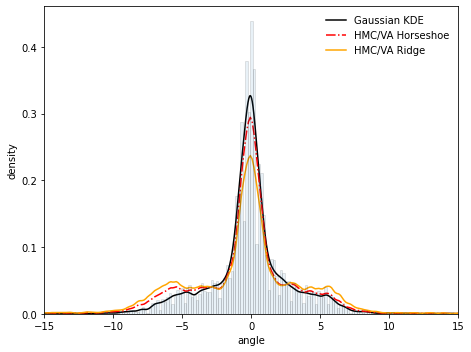

In [6]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)

# Plot the histrogram
ax.plot(support, density_gauss, color = 'black', label = 'Gaussian KDE')
ax.hist(true_y, bins=500, density=True,
        zorder=5, edgecolor='k', alpha=0.1)
ax.plot(grid, va_horse_av_den, color = 'red', linestyle= '-.', label = 'HMC/VA Horseshoe')
ax.plot(grid, va_ridge_av_den, color = 'orange', label = 'HMC/VA Ridge')
#ax.plot(grid, hmc_ridge['av_density'], color = 'orange', label = 'HMC Ridge', linestyle = '-.')
#ax.plot(grid, hmc_horse_av_den, color = 'green', linestyle= '--', label = 'HMC Horseshoe')
ax.set_xlim(-15,15)
ax.legend()
plt.legend(framealpha=0.0)
plt.xlabel('angle')
plt.ylabel('density')
fig.tight_layout(rect=[0.05, 0, 1, 1])
plt.savefig('../../../../data/commaai/calibration/marginal_calibration/marginal_calibration_cpl.png') 

## Marginal Calibration 2

In [ ]:
# get cdfs
def f_integral(i):
        return(integrate.trapz(va_horse_av_den[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
va_horse_cdf = np.cumsum(np.array(probs))

def f_integral(i):
        return(integrate.trapz(hmc_horse_av_den[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
hmc_horse_cdf = np.cumsum(np.array(probs))

def f_integral(i):
        return(integrate.trapz(va_ridge_av_den[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
va_ridge_cdf = np.cumsum(np.array(probs))

def f_integral(i):
        return(integrate.trapz(hmc_ridge_av_den[i:(i+2)], grid[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
hmc_ridge_cdf = np.cumsum(np.array(probs))

In [ ]:
Gt = []
for i in tqdm(grid):
    Gt.append(sum(x <= i for x in true_y))
Gt = np.array(Gt)/len(true_y)

In [ ]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(grid, va_horse_cdf - Gt,  color = 'red', label = 'HMC/VA Horseshoe', linestyle = '-.', linewidth = 1)
ax.plot(grid, va_ridge_cdf - Gt, color = 'orange', label = 'HMC/VA Ridge', linewidth = 1)
#ax.plot(grid, hmc_horse_cdf - Gt,  color = 'blue', label = 'VA/Horseshoe', linestyle = '-.', linewidth = 1)
#ax.plot(grid, hmc_ridge_cdf - Gt, color = 'green', linestyle= '--', label = 'HMC Horseshoe')
ax.legend()
plt.legend(framealpha=0.0)
fig.tight_layout(rect=[0.05, 0, 1, 1])
plt.xlabel('angle')
plt.autoscale()
plt.ylabel('average predictive CDF - empirical CDF')
plt.savefig('../../../../data/commaai/calibration/marginal_calibration/marginal_calibration2_cpl.png') 

## Probability Calibration

In [ ]:
help_grid = [find_closest_element(grid_i, support) for grid_i in grid]

In [ ]:
# true density
grid2 = np.array([i for i in range(0, support.shape[0])])
def f_integral(i):
    return(integrate.trapz(density_gauss[i:(i+2)], support[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, grid2)
cdf = np.cumsum(np.array(probs))

In [ ]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
#ax.plot(cdf, cdf_va- cdf, color = 'red', label = 'VA/Horseshoe')
ax.plot(cdf[help_grid], va_horse_cdf - cdf[help_grid], color = 'red', linestyle= '-.', label = 'HMC/VA Horseshoe')
ax.plot(cdf[help_grid], va_ridge_cdf - cdf[help_grid], color = 'orange', label = 'HMC/VA Ridge') #*0.9292
ax.legend()
plt.legend(framealpha=0.0)
#plt.tight_layout()
plt.autoscale()
#plt.ylim(-.2,.2)
plt.xlabel('expected confidence level')
plt.ylabel('observed - expected confidence level')
plt.savefig('../../../../data/commaai/calibration/marginal_calibration/prob_calibration_cpl.png') 